In [1]:
import sys
import os
from itertools import product
import math
import numpy
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from scipy.cluster.hierarchy import dendrogram, leaves_list
from scipy.spatial.distance import pdist
from sklearn.manifold import TSNE, MDS
# import umap
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time

sys.path.append(os.path.abspath(".."))
from distance_functions import *
import scipy.stats
import shutil
import tqdm
import random
import pickle
import gc
import itertools

# Load UTK face dataset

In [2]:
print('WARNING: This notebook will generate about 5GB of saved network representations in the utk_face_data directory.')

In [3]:
utk_face_data_root = './utk_face_data/'
utk_folder_src = utk_face_data_root + "UTKFace/"
utk_folder_classes = utk_face_data_root + "UTKFace_by_class/"
if not os.path.isdir(utk_folder_src):
    print('You must download UTKFace data')
    print('1. Download the UTKFace dataset file: UTKFace.tar.gz from https://drive.google.com/drive/folders/0BxYys69jI14kU0I1YUQyY1ZDRUE?resourcekey=0-01Pth1hq20K4kuGVkp3oBw')
    print(f'2. Unzip it in the folder {utk_face_data_root} with the command "tar -xf UTKFace.tar.gz"')
    assert(False)
    
filenames = os.listdir(utk_folder_src)

In [4]:
# shutil.rmtree(utk_folder_classes)

## Sort the UTKFace dataset by class
if not os.path.isdir(utk_folder_classes):
    print('Converting UTKFace to class-sorted file structure')
    os.mkdir(utk_folder_classes)
    for filename in tqdm.tqdm(filenames):
#         print(filename)
        age = int(filename.split('_')[0])
        new_age_folder = utk_folder_classes + str(age) + '/'
        if not os.path.isdir(new_age_folder):
            os.mkdir(new_age_folder)
        shutil.copyfile(utk_folder_src + filename, new_age_folder + filename)
else:
    print('UTKFace class-sorted file structure already constructed')

UTKFace class-sorted file structure already constructed


In [5]:
utk_dataset = torchvision.datasets.ImageFolder(utk_folder_classes)

n = 20000

mode = "eval"

reps_folder = f"reps/utk_face/{n}_{mode}/"
if not os.path.exists(reps_folder):
    os.makedirs(reps_folder)

model_names = []
file_names = os.listdir("models")
for filename in file_names:
    if filename.endswith(".pth"):
        model_names.append(filename[:-4])

model_names = [x for x in model_names if 'untrained' not in x]
print('model_names', model_names)
total_models = len(model_names)
print('number of models', total_models)

model_names ['mobilenet_v2_pretrained', 'regnet_x_8gf_pretrained', 'vgg16_pretrained', 'efficientnet_b7_pretrained', 'regnet_x_400mf_pretrained', 'mobilenet_v3_large_pretrained', 'efficientnet_b5_pretrained', 'regnet_y_8gf_pretrained', 'efficientnet_b6_pretrained', 'regnet_x_3_2gf_pretrained', 'regnet_x_1_6gf_pretrained', 'regnet_x_32gf_pretrained', 'convnext_base_pretrained', 'convnext_tiny_pretrained', 'inception_pretrained', 'convnext_small_pretrained', 'resnext50_32x4d_pretrained', 'efficientnet_b1_pretrained', 'efficientnet_b3_pretrained', 'efficientnet_b4_pretrained', 'regnet_y_32gf_pretrained', 'efficientnet_b0_pretrained', 'convnext_large_pretrained', 'wide_resnet50_2_pretrained', 'regnet_y_16gf_pretrained', 'mobilenet_v3_small_pretrained', 'regnet_y_800mf_pretrained', 'regnet_x_800mf_pretrained', 'regnet_y_3_2gf_pretrained', 'regnet_y_1_6gf_pretrained', 'efficientnet_b2_pretrained', 'regnet_x_16gf_pretrained', 'resnet18_pretrained', 'mnasnet_pretrained', 'alexnet_pretrained', 

In [6]:
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = torchvision.transforms.Compose([transforms.ToTensor(), transforms.Resize(224), normalize])
dataset = torchvision.datasets.ImageFolder(utk_folder_classes,transform=transform)

In [7]:
## Re-organize the UTK face dataset so that we can access it faster, and compute representations

temp_reps_folder = utk_face_data_root + 'temp_reps_utkface_noshuffle/'

no_cuda = False
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

stride = 200

if not os.path.isdir(temp_reps_folder):
    os.mkdir(temp_reps_folder)

    loader = torch.utils.data.DataLoader(dataset, batch_size=stride, shuffle=False, num_workers=0)

    with torch.no_grad():

        iter_num = 0
        for batch_data, batch_labels in loader:
            print('iter_num',iter_num)

            curr_batch_folder = temp_reps_folder + str(iter_num) + '/'
            if not os.path.isdir(curr_batch_folder):
                os.mkdir(curr_batch_folder)

            batch_data = batch_data.to(device)

            batch_names = model_names

            pbar = tqdm.tqdm(batch_names)
            for model_name in pbar:
                pbar.set_description(f"Processing {model_name}")
                pickle_file_name = curr_batch_folder + model_name + '.pkl'
                if os.path.exists(pickle_file_name):
                    continue


                model = torch.load(f"models/{model_name}.pth")
                model = model.to(device)
                if mode == "eval":
                    model.eval()

                activation = {}
                def get_activation(name):
                    def hook(model, input, output):
                        activation[name] = output.detach()
                    return hook

                try:
                    model.classifier[-2].register_forward_hook(get_activation("pre_classifier"))
                except:
                    list(model.children())[-2].register_forward_hook(get_activation("pre_classifier"))

                with torch.no_grad():
                    model(batch_data)
                    curr_embed = activation["pre_classifier"].flatten(start_dim=1)
    #                 print(curr_embed.shape)

                pickle.dump(curr_embed.cpu(), open(pickle_file_name, 'wb'))
                model = None
                gc.collect()

            iter_num += 1

In [8]:
print(reps_folder)

print('n',n)

for model_name in tqdm.tqdm(model_names):
    print(model_name)
    model_rep_file = reps_folder + model_name + '.pkl'
    if os.path.isfile(model_rep_file):
        print('Already exists')
        continue
    for iter_num in range(n // stride):
            
        curr_file = temp_reps_folder + str(iter_num) + '/' + model_name + '.pkl'
        if not os.path.isfile(curr_file):
            assert(False)
#         print(curr_file)
        temp_embed = pickle.load(open(curr_file, 'rb'))
        
        if iter_num == 0:
            d = temp_embed.shape[1]
            curr_embed = torch.zeros((n, d))
        
        assert(temp_embed.shape[0] == stride)
        assert(temp_embed.shape[1] == d)
        curr_embed[iter_num * stride:(iter_num+1)*stride, :] = temp_embed
    print('saving')
    pickle.dump(curr_embed, open(model_rep_file, 'wb'))

reps/utk_face/20000_eval/
n 20000


100%|██████████| 37/37 [00:00<00:00, 6974.17it/s]

mobilenet_v2_pretrained
Already exists
regnet_x_8gf_pretrained
Already exists
vgg16_pretrained
Already exists
efficientnet_b7_pretrained
Already exists
regnet_x_400mf_pretrained
Already exists
mobilenet_v3_large_pretrained
Already exists
efficientnet_b5_pretrained
Already exists
regnet_y_8gf_pretrained
Already exists
efficientnet_b6_pretrained
Already exists
regnet_x_3_2gf_pretrained
Already exists
regnet_x_1_6gf_pretrained
Already exists
regnet_x_32gf_pretrained
Already exists
convnext_base_pretrained
Already exists
convnext_tiny_pretrained
Already exists
inception_pretrained
Already exists
convnext_small_pretrained
Already exists
resnext50_32x4d_pretrained
Already exists
efficientnet_b1_pretrained
Already exists
efficientnet_b3_pretrained
Already exists
efficientnet_b4_pretrained
Already exists
regnet_y_32gf_pretrained
Already exists
efficientnet_b0_pretrained
Already exists
convnext_large_pretrained
Already exists
wide_resnet50_2_pretrained
Already exists
regnet_y_16gf_pretrained
Al

In [9]:
torch.manual_seed(1)
perm = torch.randperm(20000)
print(perm)

tensor([15845, 10294, 19532,  ...,  2032, 12413,  5718])


In [10]:
age_labels = []
for i in range(13000):
    filename = dataset.imgs[perm[i]][0]
    age_labels.append(int(filename.split('/')[3]))

In [11]:
reps_folder = 'reps/utk_face/20000_eval/'
print(reps_folder)
reps_folder_13000 = 'reps/utk_face/13000_eval/'

print('n',n)

for model_name in model_names:
    print(model_name)
    model_rep_file = reps_folder + model_name + '.pkl'
    new_file = reps_folder_13000 + model_name + '.pkl'
    if os.path.isfile(model_rep_file):
        rep = pickle.load(open(model_rep_file, 'rb'))
        rep = rep[perm[0:13000],:]
        if not os.path.isfile(new_file):
            pickle.dump(rep, open(new_file, 'wb'))
    else:
        assert(False)

reps/utk_face/20000_eval/
n 20000
mobilenet_v2_pretrained
regnet_x_8gf_pretrained
vgg16_pretrained
efficientnet_b7_pretrained
regnet_x_400mf_pretrained
mobilenet_v3_large_pretrained
efficientnet_b5_pretrained
regnet_y_8gf_pretrained
efficientnet_b6_pretrained
regnet_x_3_2gf_pretrained
regnet_x_1_6gf_pretrained
regnet_x_32gf_pretrained
convnext_base_pretrained
convnext_tiny_pretrained
inception_pretrained
convnext_small_pretrained
resnext50_32x4d_pretrained
efficientnet_b1_pretrained
efficientnet_b3_pretrained
efficientnet_b4_pretrained
regnet_y_32gf_pretrained
efficientnet_b0_pretrained
convnext_large_pretrained
wide_resnet50_2_pretrained
regnet_y_16gf_pretrained
mobilenet_v3_small_pretrained
regnet_y_800mf_pretrained
regnet_x_800mf_pretrained
regnet_y_3_2gf_pretrained
regnet_y_1_6gf_pretrained
efficientnet_b2_pretrained
regnet_x_16gf_pretrained
resnet18_pretrained
mnasnet_pretrained
alexnet_pretrained
regnet_y_400mf_pretrained
googlenet_pretrained


# Load distances and representations

In [12]:
print(reps_folder)
reps_folder = 'reps/utk_face/13000_eval'
print(reps_folder)

reps/utk_face/20000_eval/
reps/utk_face/13000_eval


In [13]:
distances_folder = "distances/utk_face/pretrained"

In [14]:
# Load the ImageNet distances between train datasets
filenames = os.listdir(distances_folder)
distnames = []
for filename in filenames:
    if filename.endswith("npy"):
        distnames.append(filename[:-4])
distnames = np.sort(distnames)

In [15]:
print(distnames)

['lin_cka_dist' 'lin_cka_prime_dist' 'mean_cca_e2e' 'mean_sq_cca_e2e'
 'predictor_dist_0.0' 'predictor_dist_0.0001' 'predictor_dist_0.001'
 'predictor_dist_0.01' 'predictor_dist_0.1' 'predictor_dist_1.0'
 'predictor_dist_10.0' 'predictor_dist_100.0' 'predictor_dist_1000.0'
 'predictor_dist_10000.0' 'predictor_dist_1e-05' 'predictor_dist_1e-06'
 'predictor_dist_1e-07' 'predictor_dist_1e-08' 'predictor_dist_1e-09'
 'predictor_dist_1e-10' 'predictor_dist_1e-11' 'predictor_dist_1e-12'
 'predictor_dist_1e-13' 'predictor_dist_1e-14' 'predictor_dist_1e-15'
 'predictor_dist_1e-16' 'predictor_dist_1e-17' 'predictor_dist_1e-18'
 'predictor_dist_1e-19' 'predictor_dist_1e-20' 'procrustes'
 'pwcca_dist_e2e']


In [16]:
stats = np.load(f"{distances_folder}/stats.npz")
model_names = stats["model_names"]
total_models = len(model_names)
dist_pairs_saved = stats["dist_pairs_saved"]

In [17]:
# Check all distance pairs are saved. The output should be all-zeros
print(np.arange(total_models) - np.sum(dist_pairs_saved, axis=0))
print(np.arange(total_models) - np.flip(np.sum(dist_pairs_saved, axis=1)))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [18]:
print(model_names)

['alexnet_pretrained' 'convnext_base_pretrained'
 'convnext_large_pretrained' 'convnext_small_pretrained'
 'convnext_tiny_pretrained' 'efficientnet_b0_pretrained'
 'efficientnet_b1_pretrained' 'efficientnet_b2_pretrained'
 'efficientnet_b3_pretrained' 'efficientnet_b4_pretrained'
 'efficientnet_b5_pretrained' 'efficientnet_b6_pretrained'
 'efficientnet_b7_pretrained' 'googlenet_pretrained'
 'inception_pretrained' 'mnasnet_pretrained' 'mobilenet_v2_pretrained'
 'mobilenet_v3_large_pretrained' 'mobilenet_v3_small_pretrained'
 'regnet_x_16gf_pretrained' 'regnet_x_1_6gf_pretrained'
 'regnet_x_32gf_pretrained' 'regnet_x_3_2gf_pretrained'
 'regnet_x_400mf_pretrained' 'regnet_x_800mf_pretrained'
 'regnet_x_8gf_pretrained' 'regnet_y_16gf_pretrained'
 'regnet_y_1_6gf_pretrained' 'regnet_y_32gf_pretrained'
 'regnet_y_3_2gf_pretrained' 'regnet_y_400mf_pretrained'
 'regnet_y_800mf_pretrained' 'regnet_y_8gf_pretrained'
 'resnet18_pretrained' 'resnext50_32x4d_pretrained' 'vgg16_pretrained'
 'wide_re

In [19]:
distances = {}
def symmetrize(A):
    n = A.shape[0]
    B = A.copy()
    B[np.tril_indices(n)] = B.T[np.tril_indices(n)]
    return B
for distname in distnames:
    print(distname)
    curr_dist = np.load(f"{distances_folder}/{distname}.npy")  
    distances[distname] = symmetrize(curr_dist)
#     print(distances[distname])

lin_cka_dist
lin_cka_prime_dist
mean_cca_e2e
mean_sq_cca_e2e
predictor_dist_0.0
predictor_dist_0.0001
predictor_dist_0.001
predictor_dist_0.01
predictor_dist_0.1
predictor_dist_1.0
predictor_dist_10.0
predictor_dist_100.0
predictor_dist_1000.0
predictor_dist_10000.0
predictor_dist_1e-05
predictor_dist_1e-06
predictor_dist_1e-07
predictor_dist_1e-08
predictor_dist_1e-09
predictor_dist_1e-10
predictor_dist_1e-11
predictor_dist_1e-12
predictor_dist_1e-13
predictor_dist_1e-14
predictor_dist_1e-15
predictor_dist_1e-16
predictor_dist_1e-17
predictor_dist_1e-18
predictor_dist_1e-19
predictor_dist_1e-20
procrustes
pwcca_dist_e2e


In [20]:
tot_reps_folder = 'reps/utk_face/13000_eval/'
n1 = 10000
n2 = 3000

# Load ImageNet representations
reps_train = {} # Train dataset
reps_val = {} # Validation dataset
try:
    for model_name in model_names:
        print(model_name)
        tot_rep = pickle.load(open(tot_reps_folder + model_name + '.pkl', 'rb'))
        rep1 = np.asarray(tot_rep[0:n1,:])
        rep1 = rep1.T
        rep2 = np.asarray(tot_rep[n1:n1+n2,:])
        rep2 = rep2.T
#         print(tot_rep.shape)
#         print(rep1.shape)
#         print(rep2.shape)
        
        # center and normalize
        rep1 = rep1 - rep1.mean(axis=1, keepdims=True)
        rep1 = rep1 / np.linalg.norm(rep1)
        rep1 = rep1 * np.sqrt(rep1.shape[1])
        reps_train[model_name] = rep1

        # center and normalize
        rep2 = rep2 - rep2.mean(axis=1, keepdims=True)
        rep2 = rep2 / np.linalg.norm(rep2)
        rep2 = rep2 * np.sqrt(rep2.shape[1])
        reps_val[model_name] = rep2
        

except FileNotFoundError as e:
    print('WARNING: IN ORDER TO RUN THIS CODE, THE UTK_FACE REPRESENTATIONS MUST COMPUTED. SEE README.')
    raise e

alexnet_pretrained
convnext_base_pretrained
convnext_large_pretrained
convnext_small_pretrained
convnext_tiny_pretrained
efficientnet_b0_pretrained
efficientnet_b1_pretrained
efficientnet_b2_pretrained
efficientnet_b3_pretrained
efficientnet_b4_pretrained
efficientnet_b5_pretrained
efficientnet_b6_pretrained
efficientnet_b7_pretrained
googlenet_pretrained
inception_pretrained
mnasnet_pretrained
mobilenet_v2_pretrained
mobilenet_v3_large_pretrained
mobilenet_v3_small_pretrained
regnet_x_16gf_pretrained
regnet_x_1_6gf_pretrained
regnet_x_32gf_pretrained
regnet_x_3_2gf_pretrained
regnet_x_400mf_pretrained
regnet_x_800mf_pretrained
regnet_x_8gf_pretrained
regnet_y_16gf_pretrained
regnet_y_1_6gf_pretrained
regnet_y_32gf_pretrained
regnet_y_3_2gf_pretrained
regnet_y_400mf_pretrained
regnet_y_800mf_pretrained
regnet_y_8gf_pretrained
resnet18_pretrained
resnext50_32x4d_pretrained
vgg16_pretrained
wide_resnet50_2_pretrained


# Predict generalization, y is age label

In [21]:
def find_best_pred(y, lmbda, reps):
    # ridge regression 
    # assume reps is dimension x number datapoints 
    rep_dim = reps.shape[0]
    numpts = reps.shape[1]
    
    return np.linalg.solve((lmbda*np.eye(rep_dim) + (reps @ reps.T) / numpts), reps@y) / numpts
    

In [22]:
def get_collected_correlations(lmbda, numtrials=50, numtrainsamples=10000):
    collected_correlations = []

    labels = []
    for ky,val in distances.items():
        if ky != 'predictor_dist_range':
            labels.append(ky)
#     print(labels)

    def flatten_upper_right_triangle(curr_mat):
        cv = []
        assert(curr_mat.shape[0] == curr_mat.shape[1])
        assert(curr_mat.shape[0] == len(model_names))
        for i in range(len(model_names)-1):
            for j in range(i+1,len(model_names)):
                cv.append(curr_mat[i,j])
        cv = np.asarray(cv)
        return cv

    dist_vecs = {}

    for distname in labels:
        dist_vecs[distname] = flatten_upper_right_triangle(distances[distname])

    for tri in range(numtrials):
        print(f'Trial {tri}')

        print('USING AGE LABELS')
        print('centering')
        avg_age = np.mean(age_labels)
        y = np.asarray(age_labels[0:numtrainsamples] - avg_age)

        preds = {}
        for model_name in model_names:
            preds[model_name] = find_best_pred(y, lmbda, reps_train[model_name][:,0:numtrainsamples])

        # For each pair, compute the squared distance between predictions, averaged over test instances 
        errs = np.zeros((len(model_names), len(model_names)))
        truelabels = np.asarray(age_labels[10000:13000]) - avg_age
        for ind1 in tqdm.tqdm(range(0, len(model_names)-1)):
            for ind2 in range(ind1+1, len(model_names)):
                cp1 = preds[model_names[ind1]].T @ reps_val[model_names[ind1]]
#                 if ind2 == ind1+1:
#                     print('stddev error',math.sqrt(np.sum((cp1 - truelabels) ** 2) / len(cp1)))
#                     print('baseline',math.sqrt(np.sum((truelabels) ** 2) / len(cp1)))
                cp2 = preds[model_names[ind2]].T @ reps_val[model_names[ind2]]
                errs[ind1, ind2] = np.linalg.norm(cp1 - cp2)
                errs[ind2, ind1] = errs[ind1, ind2]
        print(errs)
        err_vec = flatten_upper_right_triangle(errs)

        correlations = []

        for distname in labels:
            val = scipy.stats.spearmanr(err_vec, dist_vecs[distname]).correlation
            correlations.append(val)

        collected_correlations.append(correlations)
        
    return labels, collected_correlations

In [23]:
reps_train['alexnet_pretrained'].shape

(4096, 10000)

In [24]:
label_names_dict = {'lin_cka_dist': 'CKA', 'mean_sq_cca_e2e' : 'CCA', 'pwcca_dist_e2e': 'PWCCA', 'procrustes': 'Procrustes'}

label_names_dict['predictor_dist_0.0'] = 'GULP, $\lambda = 0$'
label_names_dict['predictor_dist_1e-07'] = 'GULP, $\lambda = 10^{-7}$'
label_names_dict['predictor_dist_1e-06'] = 'GULP, $\lambda = 10^{-6}$'
label_names_dict['predictor_dist_1e-05'] = 'GULP, $\lambda = 10^{-5}$'
label_names_dict['predictor_dist_0.0001'] = 'GULP, $\lambda = 10^{-4}$'
label_names_dict['predictor_dist_0.001'] = 'GULP, $\lambda = 10^{-3}$'
label_names_dict['predictor_dist_0.01'] = 'GULP, $\lambda = 10^{-2}$'
label_names_dict['predictor_dist_0.1'] = 'GULP, $\lambda = 10^{-1}$'
label_names_dict['predictor_dist_1.0'] = 'GULP, $\lambda = 1$'
label_names_dict['predictor_dist_10.0'] = 'GULP, $\lambda = 10$'

Trial 0
USING AGE LABELS
centering


100%|██████████| 36/36 [00:52<00:00,  1.47s/it]


[[  0.         559.92567442 570.6505463  ... 626.80279055 712.3036098
  590.21867599]
 [559.92567442   0.         333.23672247 ... 483.58205028 618.73862893
  411.5437952 ]
 [570.6505463  333.23672247   0.         ... 484.24290407 619.49876824
  419.94018142]
 ...
 [626.80279055 483.58205028 484.24290407 ...   0.         688.77236879
  499.86964428]
 [712.3036098  618.73862893 619.49876824 ... 688.77236879   0.
  628.48902761]
 [590.21867599 411.5437952  419.94018142 ... 499.86964428 628.48902761
    0.        ]]


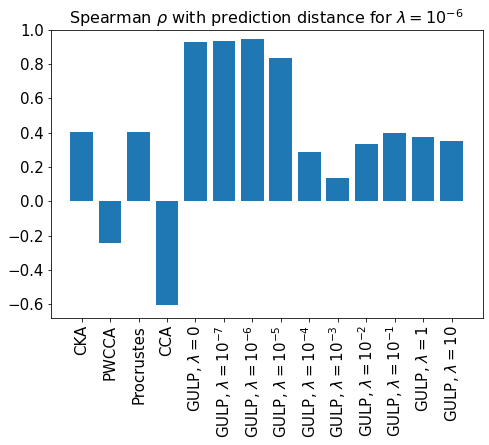

Trial 0
USING AGE LABELS
centering


100%|██████████| 36/36 [00:52<00:00,  1.45s/it]


[[  0.         332.64209594 345.45694395 ... 326.36106487 316.02383505
  334.90984033]
 [332.64209594   0.         208.87109424 ... 263.35744681 313.3796925
  260.51757708]
 [345.45694395 208.87109424   0.         ... 273.20386606 321.089631
  269.83525856]
 ...
 [326.36106487 263.35744681 273.20386606 ...   0.         300.85677284
  249.45388325]
 [316.02383505 313.3796925  321.089631   ... 300.85677284   0.
  308.37183171]
 [334.90984033 260.51757708 269.83525856 ... 249.45388325 308.37183171
    0.        ]]


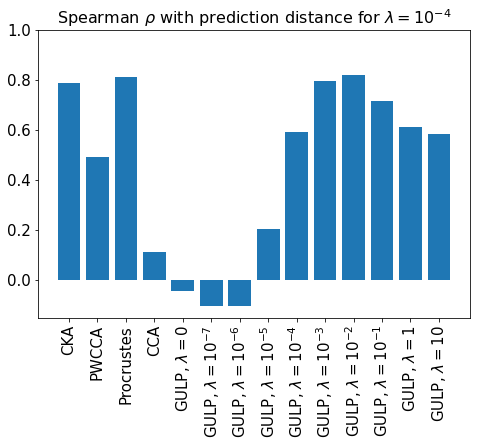

Trial 0
USING AGE LABELS
centering


100%|██████████| 36/36 [00:52<00:00,  1.45s/it]


[[  0.         255.06059168 263.4012051  ... 252.13507794 206.30776403
  250.41114588]
 [255.06059168   0.         102.09288722 ... 173.62790313 223.3705795
  166.94936762]
 [263.4012051  102.09288722   0.         ... 180.20891773 230.47165223
  173.23380197]
 ...
 [252.13507794 173.62790313 180.20891773 ...   0.         215.48088392
  148.27161071]
 [206.30776403 223.3705795  230.47165223 ... 215.48088392   0.
  220.92257483]
 [250.41114588 166.94936762 173.23380197 ... 148.27161071 220.92257483
    0.        ]]


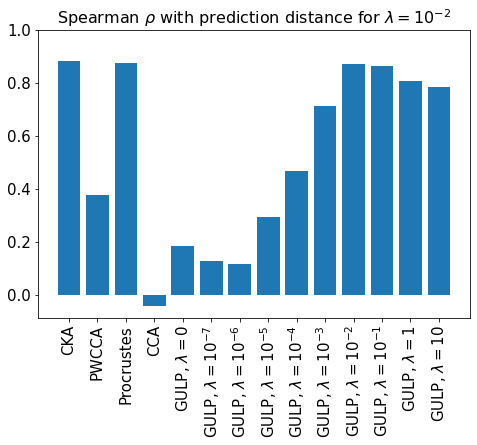

Trial 0
USING AGE LABELS
centering


100%|██████████| 36/36 [00:52<00:00,  1.46s/it]


[[ 0.         35.13124083 40.89832436 ... 51.1964226  21.62886159
  45.22926297]
 [35.13124083  0.         13.5037404  ... 33.46771512 29.65447803
  27.39930653]
 [40.89832436 13.5037404   0.         ... 31.71805544 34.57862098
  26.09015227]
 ...
 [51.1964226  33.46771512 31.71805544 ...  0.         45.21609989
  24.03882216]
 [21.62886159 29.65447803 34.57862098 ... 45.21609989  0.
  39.99528419]
 [45.22926297 27.39930653 26.09015227 ... 24.03882216 39.99528419
   0.        ]]


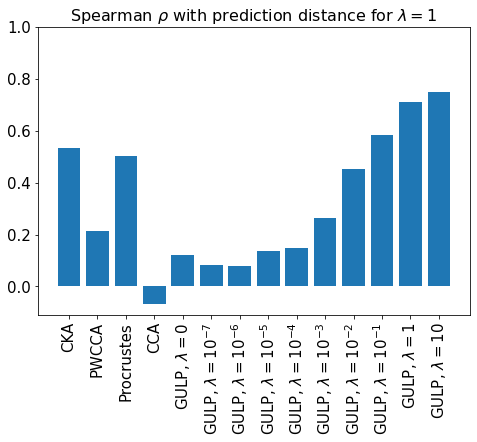

In [25]:
lmbda_vals = [1e-6,1e-4,1e-2,1]
lmbda_names = ["10^{-6}", "10^{-4}", "10^{-2}", "1"]
numtrials=1
for lmbda_ind, lmbda in enumerate(lmbda_vals):
    labels, collected_correlations = get_collected_correlations(lmbda, numtrials=numtrials,numtrainsamples=5000)
    
    std_devs = []
    means = []
    for i in range(len(collected_correlations[0])):
        cvs = [collected_correlations[j][i] for j in range(len(collected_correlations))]
        if numtrials == 1:
            std_devs.append(0)
        else:
            std_devs.append(scipy.stats.sem(cvs))
        means.append(np.mean(cvs))
    std_devs = np.array(std_devs)
    means = np.array(means)
#     print(std_devs)
    subset_labels = ['lin_cka_dist', 'pwcca_dist_e2e', 'procrustes', 'mean_sq_cca_e2e', 'predictor_dist_0.0', 'predictor_dist_1e-07', 'predictor_dist_1e-06', 'predictor_dist_1e-05', 'predictor_dist_0.0001', 'predictor_dist_0.001', 'predictor_dist_0.01', 'predictor_dist_0.1', 'predictor_dist_1.0', 'predictor_dist_10.0']
    subset_label_names = [label_names_dict[x] for x in subset_labels]
    subset_indices = []
    for i in range(len(subset_labels)):
        subset_indices.append(labels.index(subset_labels[i]))
    #     print(subset_indices)
    lbels = labels
    import matplotlib.pyplot as plt
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(range(len(subset_labels)),means[subset_indices], yerr = std_devs[subset_indices])
    plt.xticks(range(len(subset_labels)), labels=subset_label_names, rotation='vertical', fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylim(top=1)
    plt.title(f'Spearman $\\rho$ with prediction distance for $\\lambda = {lmbda_names[lmbda_ind]}$', fontsize=16)
    plt.savefig('../paper_figures/utk_generalization_lambda' + str(lmbda) + '.pdf', bbox_inches='tight')
    plt.show()